In [1]:
import numpy as np
from numpy import loadtxt
from matplotlib import pyplot as plt
%matplotlib inline
from rctorchprivate import *

import pickle
from scipy.integrate import solve_ivp as rk
import autograd
from autograd.numpy import cos, sin
solve_ivp = rk


## helper functions

In [2]:
def myMSE(prediction,target):
    return np.sqrt(np.mean((prediction.flatten() - target.flatten() )**2))

def residuals(prediction,target):
    return (target.flatten() - prediction.flatten())

def plotResults(trainlen, testlen, data, yfit, yhat, resTrain, resTest):
    """
    Arguments:
        trainlen: the length of the training set
        testlen: the length of the test set
        data: the entire dataset
        yfit: the prediction of the RC on the training set 
        yhat: the prediction of the RC on an unseen test set
        resTrain: training residuals
        resTest: test residuals
    """
    #data plot
    plt.figure(figsize=(14,6))
    plt.subplot(2,1,1)
    plt.plot(range(0,trainlen+testlen),data[:(trainlen+testlen)],'k',  linewidth=2, label="data")
    plt.plot(range(0,trainlen),yfit,'--g',  linewidth=2, alpha=0.9, label="train")
    plt.plot(range(trainlen,trainlen+testlen), yhat,'--r', linewidth=2,  alpha=1, label="test")
    lo,hi = plt.ylim()
    plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'--b',alpha=0.8, linewidth=4)
    plt.tight_layout()
    plt.ylabel('x')
    plt.legend(loc=(0.1,1.1),fontsize=18,ncol=3)

    
    #Residuals plot
    plt.subplot(2,1,2)
    plt.plot(range(0,trainlen),resTrain,'--g',  linewidth=2, alpha=0.9, label="train")
    plt.plot(range(trainlen,trainlen+testlen), resTest,'--r', linewidth=2,  alpha=1, label="test")
    lo,hi = plt.ylim()
    plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'--b',alpha=0.8, linewidth=4)
    plt.tight_layout()
    plt.ylabel('Residuals')



# simple mass spring/harmonic oscillator

In [3]:
def mass_spring(name, num_trajectories, NUM_PARTS, T_max, dt, sub_sample_rate, noise_std, seed):
    """1-body mass spring system"""

    def hamiltonian_fn(coords):
        q, p = np.split(coords, 2)

        H = (p ** 2) / 2 + (q ** 2) / 2  # spring hamiltonian (linear oscillator)
        return H

    def dynamics_fn(t, coords):
        dcoords = autograd.grad(hamiltonian_fn)(coords)
        dqdt, dpdt = np.split(dcoords, 2)
        S = np.concatenate([dpdt, -dqdt], axis=-1)
        return S

    def get_trajectory(t_span=[0, 3], timescale=0.01, ssr=sub_sample_rate, radius=None, y0=None, noise_std=0.,
                       **kwargs):

        # get initial state
#         if y0 is None:
#             y0 = np.random.rand(2) * 2 - 1
#         if radius is None:
#             radius = np.sqrt(np.random.uniform(0.5, 4.5))
#         y0 = y0 / np.sqrt((y0 ** 2).sum()) * (radius)

        y0 = [0.5,np.random.rand()]

        spring_ivp = rk(lambda t, y: dynamics_fn(t, y), t_span, y0,
                        t_eval=np.arange(0, t_span[1], timescale),method='DOP853',rtol=1e-12,
                        )

        accum = spring_ivp.y.T
        ssr = int(ssr / timescale)
        accum = accum[::ssr]

        daccum = [dynamics_fn(None, accum[i]) for i in range(accum.shape[0])]
        energies = []
        for i in range(accum.shape[0]):
            energies.append(np.sum(hamiltonian_fn(accum[i])))

        return accum, np.array(daccum), energies

    def get_dataset(name, num_trajectories, NUM_PARTS, T_max, dt, sub_sample_rate, seed=seed, test_split=0.5, **kwargs):
        data = {'meta': locals()}

        # randomly sample inputs
        np.random.seed(seed)
        data = {}
        ssr = int(sub_sample_rate / dt)

        xs, dxs, energies, ks, ms = [], [], [], [], []
        for s in range(num_trajectories):
            x, dx, energy = get_trajectory(t_span=[0, T_max], timescale=dt, ssr=sub_sample_rate)

            x += np.random.randn(*x.shape) * noise_std
            dx += np.random.randn(*dx.shape) * noise_std

            xs.append(x)
            dxs.append(dx)
            energies.append(energy)
            ks.append([1])
            ms.append([1])

        data['x'] = np.concatenate(xs)
        data['dx'] = np.concatenate(dxs)
        data['energy'] = np.concatenate(energies)
        data['ks'] = np.concatenate(ks)
        data['mass'] = np.concatenate(ms)

        f = open(name + ".pkl", "wb")
        pickle.dump(data, f)
        f.close()

        return data
    return get_dataset(name, num_trajectories, NUM_PARTS, T_max, dt, sub_sample_rate)


In [4]:
tmax = 50
data = mass_spring('test',1,1,tmax,0.1,0.1,0,1)
data1 = mass_spring('test',1,1,tmax,0.1,0.1,0,2)
data2 = mass_spring('test',1,1,tmax,0.1,0.1,0,3)
data3 = mass_spring('test',1,1,tmax,0.1,0.1,0,4)


In [9]:
data.shape

AttributeError: 'dict' object has no attribute 'shape'

In [12]:
betas = np.repeat([data['x'][0][1],data1['x'][0][1],data2['x'][0][1],data3['x'][0][1]],500)

In [13]:
train_data = np.concatenate([data['x'],data1['x'],data2['x'],data3['x']],0)

In [14]:
train_data.shape, betas.shape

((2000, 2), (2000,))

#### with feedback

### our model

$$ h_{t+1} = (1-\alpha)h_t + \alpha f(Ah_t + BY_t + W_{in}u_{in} +b)$$

to get the ham rc results we assume:

$$W_{in}u_{in} + b = \beta b $$

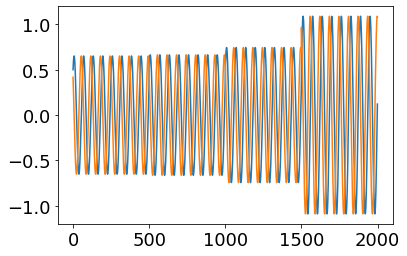

In [15]:
plt.plot(train_data)

In [16]:
def convert_numpy(arr):
    return torch.tensor(arr, dtype = torch.float32)

FAIL


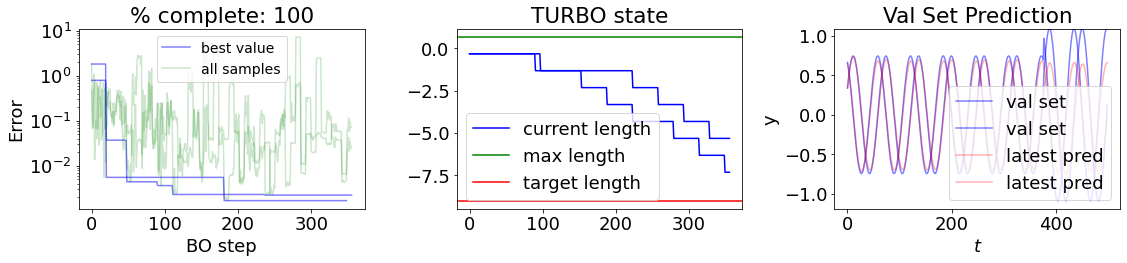

In [18]:
#declare the bounds dict. See above for which variables are optimized in linear vs logarithmic space.
bounds_dict = {"connectivity" : (-1, -0.1), 
               "spectral_radius" : (1, 2),
               "n_nodes" : 500,
               "regularization" : (-3, 3),
               "leaking_rate" : (0, 1),
               #"input_scaling" : (0, 1),
               #"feedback_scaling" : (0, 1),
               "bias": (0,1)
               }

#declare the esn_cv optimizer: this class will run bayesian optimization to optimize the bounds dict.

esn_cv = EchoStateNetworkCV(bounds = bounds_dict, esn_feedback = True, 
                            scoring_method = "mse", interactive = True, 
                            batch_size = 7, cv_samples = 1, initial_samples = 20, 
                            subsequence_length = int(train_data.shape[0] * 0.5),
                            random_seed = 209, success_tolerance = 4,
                            n_inputs = 1, n_outputs = 2)

optimized_hyper_params = esn_cv.optimize(y =convert_numpy(train_data),
                                         x=convert_numpy(betas.reshape(-1,1)),
                                         n_trust_regions = 2, max_evals = 700)

#### without feecback

In [20]:
opt_hps = optimized_hyper_params
opt_hps

{'n_nodes': 500,
 'connectivity': 0.407199571661125,
 'spectral_radius': 1.0464503765106201,
 'regularization': 52.66156010764783,
 'leaking_rate': 0.1461372971534729,
 'bias': 0.001430378295481205}

In [ ]:

# #declare the bounds dict. See above for which variables are optimized in linear vs logarithmic space.
# bounds_dict = {"connectivity" : (-1, -0.1), 
#                "spectral_radius" : (1, 2),
#                "n_nodes" : 200,
#                "regularization" : (-3, 3),
#                "leaking_rate" : (0, 1),
#                #"input_scaling" : (0, 1),
#                #"feedback_scaling" : (0, 1),
#                "bias": (0,1)
#                }

# #declare the esn_cv optimizer: this class will run bayesian optimization to optimize the bounds dict.

# esn_cv = EchoStateNetworkCV(bounds = bounds_dict, esn_feedback = False, 
#                             scoring_method = "mse", interactive = True, 
#                             batch_size = 1, cv_samples = 1, initial_samples = 20, 
#                             subsequence_length = int(ytrain.shape[0] * 0.8),
#                             random_seed = 209, success_tolerance = 4,
#                             n_inputs = 1, n_outputs = 2)
# #optimize:

# target_train = np.concatenate([xtrain.reshape(-1,1),ytrain.reshape(-1,1)],1)
# target_test = np.concatenate([xtest.reshape(-1,1),ytest.reshape(-1,1)],1)

# optimized_hyper_params_no_feedback = esn_cv.optimize(y =target_train, n_trust_regions = 2, max_evals = 500)

in hamrc they learn a single W_{out} and use this to predict other states and betas

In [21]:
betas
train_data.shape

(2000, 2)

In [22]:
train_data = torch.tensor(train_data, dtype = torch.float32)
betas = torch.tensor(betas, dtype = torch.float32).view(-1,1)

In [23]:
betas.shape, train_data.shape

(torch.Size([2000, 1]), torch.Size([2000, 2]))

In [24]:
hps = {'n_nodes': 100,
 'connectivity': 0.6475559084256522,
 'spectral_radius': 1.0265705585479736,
 'regularization': 61.27292863528506,
 'leaking_rate': 0.010949543677270412,
 'bias': 0.5907618999481201}
esn = EchoStateNetwork(**opt_hps, 
                       random_state = 209, 
                       feedback = True, 
                       id_ = 10,
                      n_inputs = 1, n_outputs = 2)

fit = esn.fit(y =train_data,X=betas.reshape(-1,1))

building states


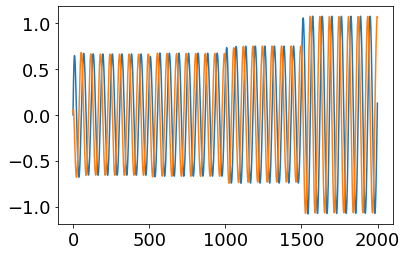

In [28]:
plt.plot(fit)

In [47]:
testdata = mass_spring('test',1,1,100,0.1,0.1,0,2)
test_target = torch.tensor(testdata['x'], dtype = torch.float32)

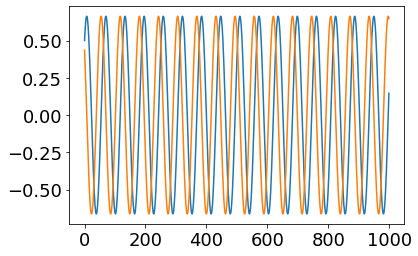

In [49]:
plt.plot(test_target)

In [50]:
testdata['x'][0][1]

0.43599490214200376

In [52]:
IC_TEST = np.repeat(testdata['x'][0][1], test_target.shape[0])
IC_TEST = torch.tensor(IC_TEST, dtype = torch.float32)

In [53]:
# fit = esn.fit(y=testdata['x'][:5000],X=IC_TEST)


In [54]:
yy = torch.tensor(testdata['x'][1:test_target.shape[0]], dtype = torch.float32)
ystartt = torch.tensor(testdata['x'][0].reshape(1,-1), dtype = torch.float32)

In [55]:
yy.shape, IC_TEST.shape, ystartt.shape

(torch.Size([999, 2]), torch.Size([1000]), torch.Size([1, 2]))

In [56]:
# transformed_t = mms.transform(tdata.reshape(-1,1)[:5000])

# ics = np.tile(IC_TEST,5000).reshape(-1,2)
# # ics += np.random.uniform(-0.01,0.01,size=ics.shape)


In [57]:
score, xhat, _ = esn.test(y = yy,
                          X = IC_TEST.reshape(-1,1)[1:],
                          y_start = ystartt)

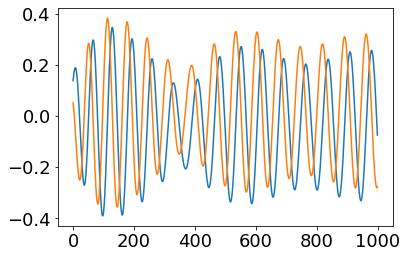

In [58]:
plt.plot(xhat)

In [66]:
np.arange(N).shape, xhat[:,i].shape

((1000,), torch.Size([999]))

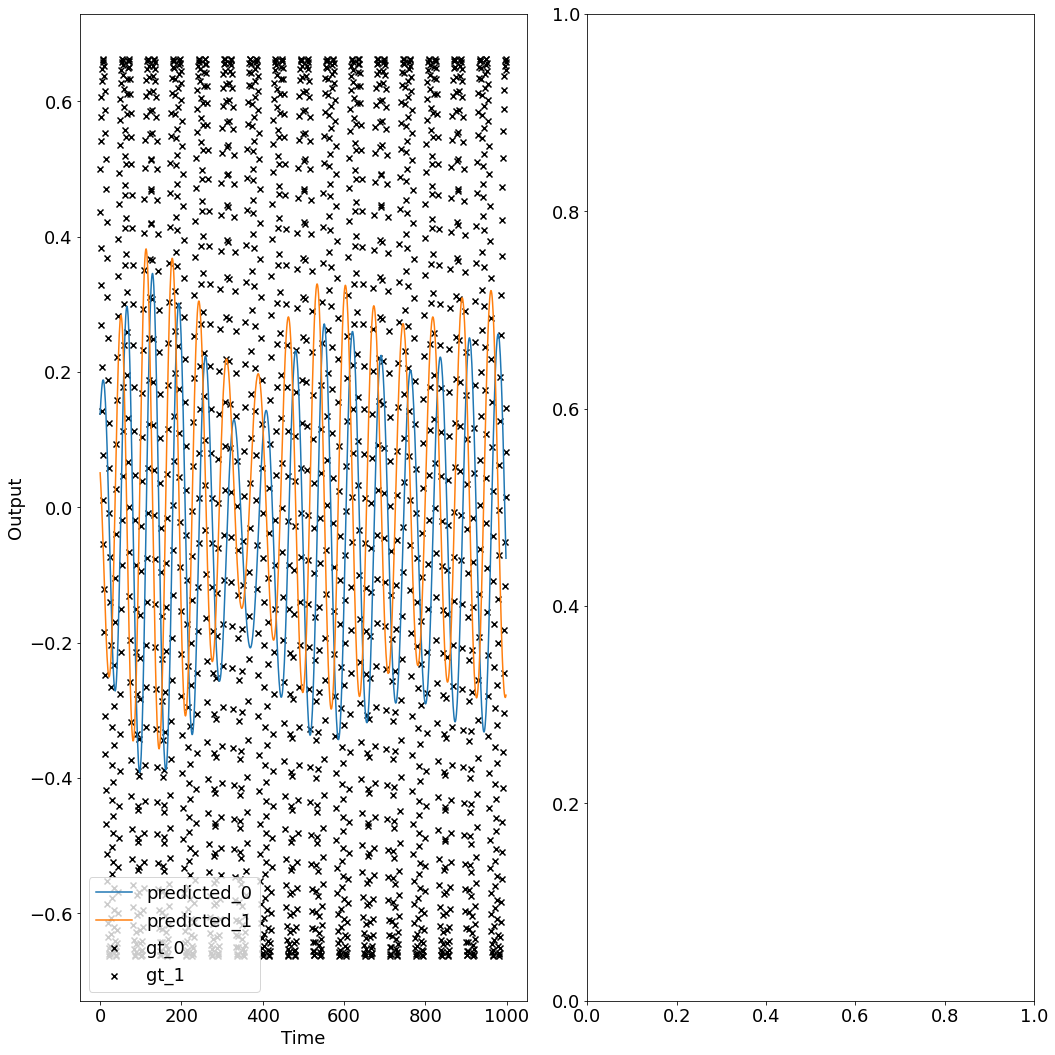

In [67]:
# plt.figure(figsize=(15,10))
fig,ax = plt.subplots(1,2,figsize=(15,15))

N = 1000
for i in range(xhat.shape[1]):
    ax[0].plot(np.arange(N-1),xhat[:N+1,i],label=f'predicted_{i}')
    ax[0].scatter(np.arange(N),testdata['x'][:N,i],marker='x',c='black',label=f'gt_{i}')
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Output')
    ax[0].legend(loc='best')

# ax[1].plot(((xhat- target_test)**2).mean(1))
# ax[1].set_xlabel('Time')
# ax[1].set_ylabel('MSE error')
# ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()

In [ ]:
#### with feedback?

# henon-heiles

In [ ]:
import pickle
from scipy.integrate import solve_ivp as rk
import autograd
from autograd.numpy import cos, sin
solve_ivp = rk
import numpy as np
def heinon_heiles(name, num_trajectories, NUM_PARTS, T_max, dt, sub_sample_rate, noise_std, seed):
    """heinon heiles data generator"""

    def hamiltonian_fn(coords):
        x, y, px, py = np.split(coords, 4)
        lambda_ = 1
        H = 0.5 * px ** 2 + 0.5 * py ** 2 + 0.5 * (x ** 2 + y ** 2) + lambda_ * (
                (x ** 2) * y - (y ** 3) / 3)
        return H

    def dynamics_fn(t, coords):
        dcoords = autograd.grad(hamiltonian_fn)(coords)
        dxdt, dydt, dpxdt, dpydt = np.split(dcoords, 4)
        S = np.concatenate([dpxdt, dpydt, -dxdt, -dydt], axis=-1)
        return S

    def get_trajectory(t_span=[0, 3], timescale=0.01, ssr=sub_sample_rate, radius=None, y0=None, noise_std=0.1,
                       **kwargs):

        # get initial state
        x = np.random.uniform(0, .4)
        y = np.random.uniform(0, .4)
        px = np.random.uniform(-.3, .3)
        py = np.random.uniform(-.3, .3)

        y0 = np.array([x, y, px, py])

        spring_ivp = rk(lambda t, y: dynamics_fn(t, y), t_span, y0,
                        t_eval=np.arange(0, t_span[1], timescale),
                        rtol=1e-12, method='DOP853')
        accum = spring_ivp.y.T
        print(accum.shape)
        ssr = int(ssr / timescale)
        accum = accum[::ssr]
        daccum = [dynamics_fn(None, accum[i]) for i in range(accum.shape[0])]
        energies = []
        for i in range(accum.shape[0]):
            energies.append(np.sum(hamiltonian_fn(accum[i])))

        return accum, np.array(daccum), energies

    def get_dataset(name, num_trajectories, NUM_PARTS, T_max, dt, sub_sample_rate, seed=seed, test_split=0.5,
                    **kwargs):
        data = {'meta': locals()}

        # randomly sample inputs
        np.random.seed(seed)
        data = {}
        ssr = int(sub_sample_rate / dt)

        xs, dxs, energies, ks, ms = [], [], [], [], []
        for s in range(num_trajectories):
            x, dx, energy = get_trajectory(t_span=[0, T_max], timescale=dt, ssr=sub_sample_rate)

            x += np.random.randn(*x.shape) * noise_std
            dx += np.random.randn(*dx.shape) * noise_std

            xs.append(x)
            dxs.append(dx)
            energies.append(energy)
            ks.append([1])
            ms.append([1])

        data['x'] = np.concatenate(xs)
        data['dx'] = np.concatenate(dxs)
        data['energy'] = np.concatenate(energies)
        data['ks'] = np.concatenate(ks)
        data['mass'] = np.concatenate(ms)

        f = open(name + ".pkl", "wb")
        pickle.dump(data, f)
        f.close()

        return data

    return get_dataset(name, num_trajectories, NUM_PARTS, T_max, dt, sub_sample_rate)


In [ ]:
data = heinon_heiles('test',1,1,500,0.1,0.1,0,3)

In [ ]:
# data = mass_spring('test',1,1,500,0.1,0.1,0,3)
tdata = np.arange(0,500,0.1)#loadtxt("data/HenonHeiles/t.dat")
xdata = data['x'][:,:2]#loadtxt("data/HenonHeiles/x.dat")
ydata = data['x'][:,2:]#loadtxt("data/HenonHeiles/y.dat")

N = len(tdata)
print("The time series consist of ", N, " points.")

plt.figure(figsize=(14,6))
plt.subplot(2,1,1)
plt.plot(tdata,xdata,'k')
plt.xlabel('t')
plt.ylabel('q(t)')
plt.subplot(2,1,2)
plt.plot(tdata,ydata,'k')
plt.ylabel('p(t)')
plt.tight_layout()



In [ ]:
trainlen = int(0.8*N)
testlen  = int(0.2*N)
trainlen = int(0.5*N)
testlen  = int(0.5*N)


# Input  data equivalents:
#ttrain = np.ones(trainlen)
#ttest=np.ones(testlen)

# ttrain = tdata[:trainlen]
# ttest  = tdata[trainlen:trainlen+testlen]

ytrain = ydata[:trainlen]
ytest  = ydata[trainlen:trainlen+testlen]

# Output data
xtrain = xdata[:trainlen]
xtest = xdata[trainlen:trainlen+testlen]

# plt.figure(figsize=(14,2))
# plt.plot(range(0,trainlen), xtrain,'r')
# plt.plot(range(trainlen,trainlen+testlen), xtest,'-g')


plt.subplot(2,1,1)
plt.plot(range(0,trainlen), xtrain,'r')
plt.plot(range(trainlen,trainlen+testlen), xtest,'-g')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.subplot(2,1,2)
plt.plot(range(0,trainlen), ytrain,'r')
plt.plot(range(trainlen,trainlen+testlen), ytest,'-g')
plt.ylabel('xdot(t)')
plt.tight_layout()




# plt.plot(ttrain, xtrain,'b')
# plt.plot(ttest, xtest,'-r')

In [ ]:
plt.plot(xdata[:,0],xdata[:,1])
plt.xlabel('x1')
plt.ylabel('x2')

In [ ]:
plt.plot(xdata[:,0],ydata[:,0])
plt.xlabel('x1')
plt.ylabel('p1')

#### with feedback

In [ ]:
#declare the bounds dict. See above for which variables are optimized in linear vs logarithmic space.
bounds_dict = {"connectivity" : (-1, -0.1), 
               "spectral_radius" : (1, 2),
               "n_nodes" : 200,
               "regularization" : (-3, 3),
               "leaking_rate" : (0, 1),
               #"input_scaling" : (0, 1),
               #"feedback_scaling" : (0, 1),
               "bias": (0,1)
               }

#declare the esn_cv optimizer: this class will run bayesian optimization to optimize the bounds dict.

esn_cv = EchoStateNetworkCV(bounds = bounds_dict, esn_feedback = True, 
                            scoring_method = "mse", interactive = True, 
                            batch_size = 1, cv_samples = 1, initial_samples = 20, 
                            subsequence_length = int(ytrain.shape[0] * 0.8),
                            random_seed = 209, success_tolerance = 4,
                            n_inputs = 1, n_outputs = 4)
#optimize:

target_train = np.concatenate([xtrain.reshape(-1,2),ytrain.reshape(-1,2)],1)
target_test = np.concatenate([xtest.reshape(-1,2),ytest.reshape(-1,2)],1)

optimized_hyper_params = esn_cv.optimize(y =target_train, n_trust_regions = 2, max_evals = 250)

#### without feecback

In [ ]:
optimized_hyper_params

In [ ]:

esn = EchoStateNetwork(**optimized_hyper_params, 
                       random_state = 209, 
                       feedback = True, 
                       id_ = 10,
                      n_inputs = 1, n_outputs = 4)

fit = esn.fit(y = target_train)

In [ ]:
score, xhat, _ = esn.test(y = target_test)

In [ ]:
# plt.figure(figsize=(15,10))
fig,ax = plt.subplots(1,2,figsize=(15,5))

N = 1000
for i in range(xhat.shape[1]):
    ax[0].plot(np.arange(N),xhat[:N,i],label=f'predicted_{i}')
    ax[0].scatter(np.arange(N),target_test[:N,i],marker='x',c='black',label=f'gt_{i}')
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Output')
    ax[0].legend(loc='best')

ax[1].plot(((xhat- target_test)**2).mean(1))
ax[1].set_xlabel('Time')
ax[1].set_ylabel('MSE error')
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()

In [ ]:
plt.plot(xhat[:,0],xhat[:,1])

In [ ]:
plt.plot(target_test[:,0],target_test[:,1])

#### double pendulum

In [ ]:
def doublepend(name, num_trajectories, NUM_PARTS, T_max, dt, sub_sample_rate, seed,hamrc=True,yflag=False):
    def hamiltonian(vec):
        m1, m2, l1, l2 = 1, 1, 1, 1
        g = 9.81
        theta1, theta2, theta1dot, theta2dot = vec
        V = -(m1 + m2) * g * l1 * np.cos(theta1) - m2 * g * l2 * np.cos(theta2)
        K = 0.5 * m1 * l1 ** 2 * (theta1dot) ** 2 + .5 * m2 * (
                l1 ** 2 * (theta1dot ** 2) + l2 ** 2 * (theta2dot ** 2) + 2 * l1 * l2 * theta1dot * theta2dot * np.cos(
            theta1 - theta2))
        # print(V+K)
        return V + K

    def omega(y):
        """
        Computes the angular velocities of the bobs and returns them
        as a tuple.
        """

        m1 = 1
        t1 = y[0]
        p1 = y[1]
        L1 = 1
        m2 = 1
        t2 = y[2]
        p2 = y[3]
        L2 = 1

        C0 = L1 * L2 * (m1 + m2 * np.sin(t1 - t2) ** 2)

        w1 = (L2 * p1 - L1 * p2 * np.cos(t1 - t2)) / (L1 * C0)
        w2 = (L1 * (m1 + m2) * p2 - L2 *
              m2 * p1 * np.cos(t1 - t2)) / (L2 * m2 * C0)

        return np.array([t1, w1, t2, w2])

   

    def f_analytical(t, state, m1, m2, l1, l2):
        g = 9.81
        t1, t2, w1, w2 = state
        a1 = (l2 / l1) * (m2 / (m1 + m2)) * np.cos(t1 - t2)
        a2 = (l1 / l2) * np.cos(t1 - t2)
        f1 = -(l2 / l1) * (m2 / (m1 + m2)) * (w2 ** 2) * np.sin(t1 - t2) - \
             (g / l1) * np.sin(t1)
        f2 = (l1 / l2) * (w1 ** 2) * np.sin(t1 - t2) - (g / l2) * np.sin(t2)
        g1 = (f1 - a1 * f2) / (1 - a1 * a2)
        g2 = (f2 - a2 * f1) / (1 - a1 * a2)
        return np.array([w1, w2, g1, g2])

    collater = {}
    theta = []
    dtheta = []
    energy = []
    mass_arr = []
    ls_arr = []
    np.random.seed(seed)

    for traj in range(num_trajectories):

        t1init = np.random.uniform(-np.pi, np.pi)
        t2init = np.random.uniform(-np.pi, np.pi)
        # p1init = np.random.uniform(-0.01, 0.01)
        # p2init = np.random.uniform(-0.01, 0.01)
        y0 = np.array([t1init, t2init,0, 0])
        if yflag:
            y0=[-0.53202021, -0.38343444, -2.70467816,  0.98074028]
#             y0 = np.array([3*np.pi/7,3*np.pi/4,0,0])#np.array([t1init, t2init, 0, 0])
        if hamrc:
            y0 = [0.6,1.35,0.,0.]
        l1, l2, m1, m2 = [1, 1, 1, 1]
        qnrk = rk(lambda t, y: f_analytical(t, y, m1, m2, l1, l2), (0, T_max), y0,
                  t_eval=np.arange(0, T_max, dt),
                  rtol=1e-12, atol=1e-12)

        accum = qnrk.y.T
        ssr = int(sub_sample_rate / dt)
        accum = accum[::ssr]

        daccum = [f_analytical(0, accum[i], m1, m2, l1, l2) for i in range(accum.shape[0])]
        energies = []
        for i in range(accum.shape[0]):
            energies.append(hamiltonian(accum[i]))


        temp_vec = accum
        theta.append(temp_vec)
        dtheta.append(daccum)
        energy.append(energies)
        mass_arr.append([m1, m2])
        ls_arr.append([l1, l2])

    collater['x'] = np.concatenate(theta)
    collater['dx'] = np.concatenate(dtheta)
    collater['energy'] = np.concatenate(energy)
    collater['mass'] = mass_arr
    collater['ks'] = ls_arr
    f = open(name + ".pkl", "wb")
    pickle.dump(collater, f)
    f.close()

    return collater


In [ ]:
# name, num_trajectories, NUM_PARTS, T_max, dt, sub_sample_rate, seed,yflag=False):
data = doublepend('test',1,2,3000,0.1,0.1,3,5)

In [ ]:
plt.figure()
for i in range(len(data['x'])):
    if np.round(data['x'][i,2],2) == 0.0 and data['x'][i,0] > 0:
        plt.scatter(data['x'][i,1],data['x'][i,3])

In [ ]:
fig,ax = plt.subplots(4,1,figsize=(7,10))
ax[0].plot(data['x'][:200,0],label='t1')
ax[1].plot(data['x'][:200,2],label='w1')
ax[2].plot(data['x'][:200,1],label='t2')
ax[3].plot(data['x'][:200,3],label='w2')
plt.legend()

In [ ]:
N = len(data['x'])
trainlen = int(0.8*N)
testlen  = int(0.2*N)
trainlen = int(0.5*N)
testlen  = int(0.5*N)

ytrain = data['x'][:trainlen]
ytest  = data['x'][trainlen:trainlen+testlen]



In [ ]:
#declare the bounds dict. See above for which variables are optimized in linear vs logarithmic space.
bounds_dict = {"connectivity" : (-1, -0.1), 
               "spectral_radius" : (1, 2),
               "n_nodes" : 200,
               "regularization" : (-3, 3),
               "leaking_rate" : (0, 1),
               #"input_scaling" : (0, 1),
               #"feedback_scaling" : (0, 1),
               "bias": (0,1)
               }

#declare the esn_cv optimizer: this class will run bayesian optimization to optimize the bounds dict.

esn_cv = EchoStateNetworkCV(bounds = bounds_dict, esn_feedback = True, 
                            scoring_method = "mse", interactive = True, 
                            batch_size = 1, cv_samples = 1, initial_samples = 20, 
                            subsequence_length = int(ytrain.shape[0] * 0.8),
                            random_seed = 209, success_tolerance = 4,
                            n_inputs = 1, n_outputs = 4)
#optimize:

# target_train = np.concatenate([xtrain.reshape(-1,2),ytrain.reshape(-1,2)],1)
# target_test = np.concatenate([xtest.reshape(-1,2),ytest.reshape(-1,2)],1)

optimized_hyper_params = esn_cv.optimize(y =ytrain, n_trust_regions = 2, max_evals = 250)

In [ ]:

esn = EchoStateNetwork(**optimized_hyper_params, 
                       random_state = 209, 
                       feedback = True, 
                       id_ = 10,
                      n_inputs = 1, n_outputs = 4)

fit = esn.fit(y = ytrain)

In [ ]:
score, xhat, _ = esn.test(y = ytest)

In [ ]:
# plt.figure(figsize=(15,10))
fig,ax = plt.subplots(1,2,figsize=(15,5))

N = 1000
for i in range(xhat.shape[1]):
    ax[0].plot(np.arange(N),xhat[:N,i],label=f'predicted_{i}')
    ax[0].scatter(np.arange(N),ytest[:N,i],marker='x',c='black',label=f'gt_{i}')
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Output')
    ax[0].legend(loc='best')

ax[1].plot(((xhat- ytest)**2).mean(1))
ax[1].set_xlabel('Time')
ax[1].set_ylabel('MSE error')
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()

In [ ]:
plt.plot(xhat[:,0],xhat[:,1])

In [ ]:
plt.plot(ytest[:,0],ytest[:,1])